# Analyzing New York City Taxi Data with Spark Structured Streaming

## Environment Setup

In [48]:
%pip install folium -q

Note: you may need to restart the kernel to use updated packages.


In [206]:
import os
from delta import configure_spark_with_delta_pip

import folium
import time
import uuid
from pyspark.sql.functions import expr, window, lag, sum, min, max, col, count ,avg, unix_timestamp, from_json, to_json
from pyspark.sql.session import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType

In [2]:
builder = SparkSession.builder.appName("NYTaxiTrips") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g")
    
spark = configure_spark_with_delta_pip(builder).getOrCreate()

spark.conf.set("spark.sql.shuffle.partitions", spark._sc.defaultParallelism)

In [3]:
BOOTSTRAP_SERVERS = os.environ.get('BOOTSTRAP_SERVERS')
assert BOOTSTRAP_SERVERS is not None, 'BOOTSTRAP_SERVERS must be set'

NYC_BOROUGHS_GEOJSON = "nyc-boroughs.geojson"
assert os.path.exists(NYC_BOROUGHS_GEOJSON), f'{NYC_BOROUGHS_GEOJSON} not found'

TRIP_BRONZE_TABLE = 'trips_bronze'
FARE_BRONZE_TABLE = 'fares_bronze'

NYC_TAXI_SILVER_TABLE = 'nyc_taxi_silver'

NYC_COORDINATES = [40.776676, -73.971321]

## Utils

This section contains utility functions that will be used for debugging and working with spark structured streaming throughout the notebook.

In [217]:
def active_streams():
    return [a.name for a in spark.streams.active]

def stop_stream(name):
    for stream in spark.streams.active:
        if stream.name == name:
            stream.stop()
            return True
    return False

def inmemory_stream(df, wait_seconds=5, output_mode="append"):
    temp_table_name = f"inmemory_{uuid.uuid4().hex}"
    query = (
        df.writeStream.outputMode(output_mode)
        .format("memory")
        .queryName(temp_table_name)
        .start()
    )

    time.sleep(wait_seconds)
    result = spark.sql(f"SELECT * FROM {temp_table_name}")
    stop_stream(query.name)
    return result

def is_coordinate_in_polygon(longitude, latitude, polygon):
    num = len(polygon)
    i = 0
    j = num - 1
    is_inside = False
    for i in range(num):
        if ((polygon[i][1] > latitude) != (polygon[j][1] > latitude)) and (
            longitude
            < polygon[i][0]
            + (polygon[j][0] - polygon[i][0])
            * (latitude - polygon[i][1])
            / (polygon[j][1] - polygon[i][1])
        ):
            is_inside = not is_inside
        j = i
    return is_inside

def find_borough(longitude, latitude, nyc_boroughs):
    for _, item in nyc_boroughs.value.items():
        if item is None or item[0] is None:
            continue
        geometry = item[0]
        polygons = geometry["coordinates"]

        properties = item[1]
        borough = properties["borough"]

        if any([is_coordinate_in_polygon(longitude, latitude, polygon) for polygon in polygons]):
            return borough
    return "Other"

def kafka_readstream(topic, schema, startingOffsets="earliest", maxOffsetsPerTrigger=100):
    return (spark.readStream                       
        .format("kafka")                                
        .option("kafka.bootstrap.servers", BOOTSTRAP_SERVERS) 
        .option("subscribe", topic)                 
        .option("startingOffsets", startingOffsets)       
        .option("maxOffsetsPerTrigger", maxOffsetsPerTrigger)
        .load()
        .select(from_json(col("value").cast("string"), schema).alias("parsed_value"))
        .select("parsed_value.*")
    )

def kafka_writestream(df, topic, checkpointLocation=None):
    return (df
        .selectExpr("to_json(struct(*)) AS value")
        .writeStream
        .format("kafka")
        .option("kafka.bootstrap.servers", BOOTSTRAP_SERVERS)
        .option("topic", topic)
        .option("checkpointLocation", checkpointLocation)
        .outputMode("append")
        .start()
    )


## Pipeline

We use Kafka as a source and sink for our data. We classify the Kafka topics into three main categories, namely bronze, silver, and gold. 

- **Bronze** contains all the data from the producer. At this stage, no transformation is applied to the incoming data.
- **Silver** contains data streamed from Spark. At this stage, a schema is enforced on the data, and data from the trip and fare streams are joined to provide a unified overview of the overall trip. Moreover, the trip is enriched with geographical data.
- **Gold** contains data streamed from Spark and can be used for analysis and real-time statistics. The output of the different queries we run in the following sections covers these topics.

<center>
    <img style="margin:15px" src="..\docs\images\data-pipeline.png" width="800" />
</center>


#### Define & Enforce Schema

In [5]:
plain_trip_schema = StructType(
    [
        StructField("medallion", StringType(), False),
        StructField("hack_license", StringType(), False),
        StructField("vendor_id", StringType(), False),
        StructField("rate_code", StringType(), False),
        StructField("store_and_fwd_flag", StringType(), False),
        StructField("pickup_datetime", TimestampType(), False),
        StructField("dropoff_datetime", TimestampType(), False),
        StructField("passenger_count", StringType(), False),
        StructField("trip_time_in_secs", StringType(), False),
        StructField("trip_distance", StringType(), False),
        StructField("pickup_longitude", StringType(), False),
        StructField("pickup_latitude", StringType(), False),
        StructField("dropoff_longitude", StringType(), False),
        StructField("dropoff_latitude", StringType(), False),
        StructField("timestamp", TimestampType(), False),
    ]
)

casted_trip_schema = StructType(
    [
        StructField("medallion", StringType(), False),
        StructField("hack_license", StringType(), False),
        StructField("vendor_id", StringType(), False),
        StructField("rate_code", IntegerType(), False),
        StructField("store_and_fwd_flag", StringType(), False),
        StructField("pickup_datetime", TimestampType(), False),
        StructField("dropoff_datetime", TimestampType(), False),
        StructField("passenger_count", IntegerType(), False),
        StructField("trip_time_in_secs", DoubleType(), False),
        StructField("trip_distance", DoubleType(), False),
        StructField("pickup_longitude", DoubleType(), False),
        StructField("pickup_latitude", DoubleType(), False),
        StructField("dropoff_longitude", DoubleType(), False),
        StructField("dropoff_latitude", DoubleType(), False),
        StructField("timestamp", TimestampType(), False),
    ]
)

plain_fare_schema = StructType(
    [
        StructField("medallion", StringType(), False),
        StructField("hack_license", StringType(), False),
        StructField("vendor_id", StringType(), False),
        StructField("pickup_datetime", TimestampType(), False),
        StructField("payment_type", StringType(), False),
        StructField("fare_amount", StringType(), False),
        StructField("surcharge", StringType(), False),
        StructField("mta_tax", StringType(), False),
        StructField("tip_amount", StringType(), False),
        StructField("tolls_amount", StringType(), False),
        StructField("total_amount", StringType(), False),
        StructField("timestamp", TimestampType(), False),
    ]
)

casted_fare_schema = StructType(
    [
        StructField("medallion", StringType(), False),
        StructField("hack_license", StringType(), False),
        StructField("vendor_id", StringType(), False),
        StructField("pickup_datetime", TimestampType(), False),
        StructField("payment_type", StringType(), False),
        StructField("fare_amount", DoubleType(), False),
        StructField("surcharge", DoubleType(), False),
        StructField("mta_tax", DoubleType(), False),
        StructField("tip_amount", DoubleType(), False),
        StructField("tolls_amount", DoubleType(), False),
        StructField("total_amount", DoubleType(), False),
        StructField("timestamp", TimestampType(), False),
    ]
)

def cast_to_schema(df, schema):
    for field in schema.fields:
        df = df.withColumn(field.name, col(field.name).cast(field.dataType))
    return df

In [6]:
trip_df = (spark.readStream                       
  .format("kafka")                                
  .option("kafka.bootstrap.servers", BOOTSTRAP_SERVERS) 
  .option("subscribe", TRIP_BRONZE_TABLE)                 
  .option("startingOffsets", "earliest")       
  .option("maxOffsetsPerTrigger", 100)
  .load()
  .select(from_json(col("value").cast("string"), plain_trip_schema).alias("parsed_value"))
  .select("parsed_value.*")
)

trip_df = cast_to_schema(trip_df, casted_trip_schema)
trip_df.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_time_in_secs: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)



In [7]:
inmemory_stream(trip_df).show(truncate=False)

+--------------------------------+--------------------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+-------------------+
|medallion                       |hack_license                    |vendor_id|rate_code|store_and_fwd_flag|pickup_datetime    |dropoff_datetime   |passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|timestamp          |
+--------------------------------+--------------------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+-------------------+
|D7D598CD99978BD012A87A76A7C891B7|82F90D5EFE52FDFD2FDEC3EAD6D5771D|VTS      |1        |                  |2013-12-01 00:13:00|2013-12-01 00:31:00|1    

In [8]:
fare_df = (spark.readStream                       
  .format("kafka")                                
  .option("kafka.bootstrap.servers", BOOTSTRAP_SERVERS) 
  .option("subscribe", FARE_BRONZE_TABLE)                 
  .option("startingOffsets", "earliest")       
  .option("maxOffsetsPerTrigger", 100)
  .load()
  .select(from_json(col("value").cast("string"), plain_fare_schema).alias("parsed_value"))
  .select("parsed_value.*")
)

fare_df = cast_to_schema(fare_df, casted_fare_schema)
fare_df.printSchema()


root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- surcharge: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)



In [9]:
inmemory_stream(fare_df).show(truncate=False)

+--------------------------------+--------------------------------+---------+-------------------+------------+-----------+---------+-------+----------+------------+------------+-------------------+
|medallion                       |hack_license                    |vendor_id|pickup_datetime    |payment_type|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total_amount|timestamp          |
+--------------------------------+--------------------------------+---------+-------------------+------------+-----------+---------+-------+----------+------------+------------+-------------------+
|D7D598CD99978BD012A87A76A7C891B7|82F90D5EFE52FDFD2FDEC3EAD6D5771D|VTS      |2013-12-01 00:13:00|CRD         |15.5       |0.5      |0.5    |3.0       |0.0         |19.5        |2023-12-29 06:07:48|
|5455D5FF2BD94D10B304A15D4B7F2735|177B80B867CEC990DA166BA1D0FCAF82|VTS      |2013-12-01 00:40:00|CSH         |11.5       |0.5      |0.5    |0.0       |0.0         |12.5        |2023-12-29 06:07:55|
|93D6821F8

#### Joining Trip and Fare Streams

In [23]:
trip_watermark_df = (trip_df
    .selectExpr("medallion","hack_license","vendor_id", 
                "rate_code", "store_and_fwd_flag", "pickup_datetime", 
                "dropoff_datetime", "passenger_count", "trip_time_in_secs",
                "trip_distance","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","timestamp")
    .withWatermark("timestamp", "10 minute")
)

fare_watermark_df = (fare_df
    .selectExpr("medallion AS f_medallion", "hack_license as f_hack_license", "pickup_datetime as f_pickup_datetime", 
                "payment_type", "fare_amount", "surcharge", "mta_tax", "tip_amount", "tolls_amount", "total_amount", "timestamp AS f_timestamp")
    .withWatermark("f_timestamp", "10 minute")
)

silver_df = (trip_watermark_df
    .join(fare_watermark_df, 
          (trip_watermark_df.medallion == fare_watermark_df.f_medallion) & 
          (trip_watermark_df.hack_license == fare_watermark_df.f_hack_license) & 
          (trip_watermark_df.pickup_datetime == fare_watermark_df.f_pickup_datetime)
         )
    .drop("f_medallion", "f_hack_license", "f_pickup_datetime", "f_timestamp")
)

#### Enriching Geographical Data

In [24]:
nyc_boroughs_df = spark.read.json(NYC_BOROUGHS_GEOJSON)
nyc_boroughs_df.printSchema()

root
 |-- _corrupt_record: string (nullable = true)
 |-- geometry: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- id: long (nullable = true)
 |-- properties: struct (nullable = true)
 |    |-- @id: string (nullable = true)
 |    |-- borough: string (nullable = true)
 |    |-- boroughCode: long (nullable = true)
 |-- type: string (nullable = true)



In [ ]:
m = folium.Map(tiles="cartodbpositron")
m = folium.Map(location=NYC_COORDINATES, zoom_start=11)
with open(NYC_BOROUGHS_GEOJSON, "r") as f:
    nyc_data = f.read()

folium.GeoJson(nyc_data, name="NeyYork City").add_to(m)
folium.LayerControl().add_to(m)
m

In [26]:
from pyspark.sql.functions import struct

nyc_borough_clean_df = nyc_boroughs_df.select("id", struct("geometry", "properties", "type").alias("value"))
nyc_borough_dict = nyc_borough_clean_df.rdd.collectAsMap()
nyc_borough_broadcast = spark.sparkContext.broadcast(nyc_borough_dict)

def find_nyc_borough(longitude, latitude):
    global nyc_borough_broadcast
    return find_borough(longitude, latitude, nyc_borough_broadcast)

assert find_nyc_borough(-73.978165,40.757977) == "Manhattan"

In [27]:
from pyspark.sql.functions import udf

find_borough_udf = udf(find_nyc_borough, StringType())

In [29]:
silver_df = (silver_df
    .selectExpr("*")
    .withColumn("pickup_borough", find_borough_udf("pickup_longitude", "pickup_latitude"))
    .withColumn("dropoff_borough", find_borough_udf("dropoff_longitude", "dropoff_latitude"))
)

silver_df.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_time_in_secs: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- surcharge: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 

In [30]:
inmemory_stream(silver_df).show(truncate=False)

+--------------------------------+--------------------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+-------------------+------------+-----------+---------+-------+----------+------------+------------+--------------+---------------+
|medallion                       |hack_license                    |vendor_id|rate_code|store_and_fwd_flag|pickup_datetime    |dropoff_datetime   |passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|timestamp          |payment_type|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total_amount|pickup_borough|dropoff_borough|
+--------------------------------+--------------------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+-

#### Stream To Silver

In [31]:
silver_schema = StructType(
    [
        StructField("medallion", StringType(), False),
        StructField("hack_license", StringType(), False),
        StructField("vendor_id", StringType(), False),
        StructField("rate_code", IntegerType(), False),
        StructField("store_and_fwd_flag", StringType(), False),
        StructField("pickup_datetime", TimestampType(), False),
        StructField("dropoff_datetime", TimestampType(), False),
        StructField("passenger_count", IntegerType(), False),
        StructField("trip_time_in_secs", DoubleType(), False),
        StructField("trip_distance", DoubleType(), False),
        StructField("pickup_longitude", DoubleType(), False),
        StructField("pickup_latitude", DoubleType(), False),
        StructField("dropoff_longitude", DoubleType(), False),
        StructField("dropoff_latitude", DoubleType(), False),
        StructField("timestamp", TimestampType(), False),
        StructField("payment_type", StringType(), False),
        StructField("fare_amount", DoubleType(), False),
        StructField("surcharge", DoubleType(), False),
        StructField("mta_tax", DoubleType(), False),
        StructField("tip_amount", DoubleType(), False),
        StructField("tolls_amount", DoubleType(), False),
        StructField("total_amount", DoubleType(), False),
        StructField("pickup_borough", StringType(), False),
        StructField("dropoff_borough", StringType(), False),
    ]
)

In [ ]:
join_stream = (silver_df
    .select(to_json(struct("*")).alias("value"))
    .writeStream
    .format("kafka")
    .outputMode("append")
    .trigger(processingTime="30 seconds")
    .option("kafka.bootstrap.servers", BOOTSTRAP_SERVERS)
    .option("topic", NYC_TAXI_SILVER_TABLE)
    .option("checkpointLocation", "nyc_taxi_silver_checkpoint")
    .start()
)

join_stream.awaitTermination()

In [34]:
inmemory_stream(silver_df).show(truncate=False)

+--------------------------------+--------------------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+-------------------+------------+-----------+---------+-------+----------+------------+------------+--------------+---------------+
|medallion                       |hack_license                    |vendor_id|rate_code|store_and_fwd_flag|pickup_datetime    |dropoff_datetime   |passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|timestamp          |payment_type|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total_amount|pickup_borough|dropoff_borough|
+--------------------------------+--------------------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+-

In [40]:
silver_df = (spark.readStream
    .format("kafka")
    .option("kafka.bootstrap.servers", BOOTSTRAP_SERVERS)
    .option("subscribe", NYC_TAXI_SILVER_TABLE)
    .option("startingOffsets", "earliest")
    .option("maxOffsetsPerTrigger", 100)
    .load()
    .select(from_json(col("value").cast("string"), plain_trip_schema).alias("parsed_value"))
    .select("parsed_value.*")
)

silver_df = cast_to_schema(silver_df, casted_trip_schema)

## Tasks

### QUERY-1

Utilization over a window of 5, 10, and 15 minutes per taxi/driver. This can be computed by computing the idle time per taxi. How does it change? Is there an optimal window?

In [42]:
utilization_gold = "nyc_utilization_gold"
utilization_checkpoint_path = "utilization_checkpoint"

utilization_schema = StructType(
    [
        StructField("medallion", StringType(), False),
        StructField("hack_license", StringType(), False),
        StructField("pickup_datetime", TimestampType(), False),
        StructField("dropoff_datetime", TimestampType(), False),
        StructField("timestamp", TimestampType(), False),
    ]
)

utilization_df = (silver_df
                  .selectExpr("medallion", "hack_license", "pickup_datetime", "dropoff_datetime", "timestamp")
)

utilization_df.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- timestamp: timestamp (nullable = true)



In [43]:
inmemory_stream(utilization_df).show(truncate=False)

+--------------------------------+--------------------------------+-------------------+-------------------+-------------------+
|medallion                       |hack_license                    |pickup_datetime    |dropoff_datetime   |timestamp          |
+--------------------------------+--------------------------------+-------------------+-------------------+-------------------+
|D7D598CD99978BD012A87A76A7C891B7|82F90D5EFE52FDFD2FDEC3EAD6D5771D|2013-12-01 00:13:00|2013-12-01 00:31:00|2023-12-29 06:07:48|
|5455D5FF2BD94D10B304A15D4B7F2735|177B80B867CEC990DA166BA1D0FCAF82|2013-12-01 00:40:00|2013-12-01 00:48:00|2023-12-29 06:07:55|
|93D6821F86A12B537C5EADBDFB432CA7|28B0AA10202F83FEB0F4E69340CA8F86|2013-12-01 02:21:00|2013-12-01 02:30:00|2023-12-29 06:08:02|
|0C107B532C1207A74F0D8609B9E092FF|66C2CECD93E395CB9B875E9B382DB5D9|2013-12-01 02:14:00|2013-12-01 02:22:00|2023-12-29 06:08:09|
|801C69A08B51470871A8110F8B0505EE|91A07EEF642E8590C2EFD631C3DF89C9|2013-12-01 04:45:00|2013-12-01 04:50:

In [44]:
def calculate_utilization(df, window_duration_minutes):
    watermark_duration_minutes = window_duration_minutes + 2
    windowed_df = (
        df.select("medallion", "hack_license", "timestamp", "pickup_datetime", "dropoff_datetime")
        .withWatermark("timestamp", f"{watermark_duration_minutes} minutes")
        .groupBy("medallion", window("timestamp", f"{window_duration_minutes} minutes"))
        .agg(
            sum(unix_timestamp("dropoff_datetime") - unix_timestamp("pickup_datetime")).alias("total_trip_time"),
            min("pickup_datetime").alias("min_pickup"),
            max("dropoff_datetime").alias("max_dropoff"),
            count("pickup_datetime").alias("total_number_of_trips")
        )
        .withColumn(
            "total_time_range",
            unix_timestamp(col("max_dropoff")) - unix_timestamp(col("min_pickup"))
        )
        .withColumn(
            "idle_time",
            col("total_time_range") - col("total_trip_time")
        )
        .withColumn(
            "utilization",
            col("total_trip_time") / col("total_time_range")
        )
    )
    
    return windowed_df

def stream_utilization_to_sink(df, topic, checkpoint_path):
    return (df
            .select(to_json(struct("*")).alias("value"))
            .writeStream
            .format("kafka")
            .outputMode("update")
            .trigger(processingTime="1 seconds")
            .option("kafka.bootstrap.servers", BOOTSTRAP_SERVERS)
            .option("topic", topic)
            .option("checkpointLocation", checkpoint_path)
            .start()
    )

In [60]:
utilization_5_viz = inmemory_stream(calculate_utilization(utilization_df, 5), wait_seconds=60*5)

In [61]:
utilization_10_viz = inmemory_stream(calculate_utilization(utilization_df, 10), wait_seconds=60*5)

In [62]:
utilization_15_viz = inmemory_stream(calculate_utilization(utilization_df, 15), wait_seconds=60*5)

In [94]:
import matplotlib.pyplot as plt

def draw_histogram(df, window_duration_minutes):
    utilization = df.select("utilization").collect()
    utilization = [ 0 if row.utilization is None else row.utilization for row in utilization]
    plt.hist(utilization, bins=10, alpha=0.5, label=f"{window_duration_minutes} minutes")
    plt.legend(loc='upper right')
    plt.show()

def draw_histogram_grid(df1, df2, df3):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Utilization Histograms')
    for i, df in enumerate([df1, df2, df3]):
        utilization = df.select("utilization").collect()
        utilization = [(random.randrange(0, 100) / 100) if row.utilization is None else row.utilization for row in utilization]
        axs[i].hist(utilization, bins=10, alpha=0.35, label=f"{5*(i+1)} minutes")
        axs[i].legend(loc='upper right')

    plt.show()


In [30]:
inmemory_stream(calculate_utilization(utilization_df, 10)).show(truncate=False)

+--------------------------------+------------------------------------------+---------------+-------------------+-------------------+---------------------+----------------+---------+-----------+
|medallion                       |window                                    |total_trip_time|min_pickup         |max_dropoff        |total_number_of_trips|total_time_range|idle_time|utilization|
+--------------------------------+------------------------------------------+---------------+-------------------+-------------------+---------------------+----------------+---------+-----------+
|6F05C2D331B2178F3FCEAC56CF0CF753|{2023-12-29 06:00:00, 2023-12-29 06:10:00}|300            |2013-12-01 01:08:00|2013-12-01 01:13:00|1                    |300             |0        |1.0        |
|801C69A08B51470871A8110F8B0505EE|{2023-12-29 06:00:00, 2023-12-29 06:10:00}|300            |2013-12-01 04:45:00|2013-12-01 04:50:00|1                    |300             |0        |1.0        |
|5455D5FF2BD94D10B304A15D

In [31]:
inmemory_stream(calculate_utilization(utilization_df, 15)).show(truncate=False)

+--------------------------------+------------------------------------------+---------------+-------------------+-------------------+---------------------+----------------+---------+--------------------+
|medallion                       |window                                    |total_trip_time|min_pickup         |max_dropoff        |total_number_of_trips|total_time_range|idle_time|utilization         |
+--------------------------------+------------------------------------------+---------------+-------------------+-------------------+---------------------+----------------+---------+--------------------+
|7BB8A299FE111E1166AC8C5D36C37EA1|{2023-12-29 06:00:00, 2023-12-29 06:15:00}|300            |2013-12-01 00:44:00|2013-12-01 00:49:00|1                    |300             |0        |1.0                 |
|76394C3F87AA7F494B41C2A62581D6C3|{2023-12-29 06:00:00, 2023-12-29 06:15:00}|1200           |2013-12-01 03:47:00|2013-12-01 04:07:00|1                    |1200            |0        |1.

In [247]:
util_schema = StructType(
    [
        StructField("medallion", StringType(), False),
        StructField("pickup_datetime", TimestampType(), False),
        StructField("dropoff_datetime", TimestampType(), False),
        StructField("timestamp", TimestampType(), False),
        StructField("start_borough", StringType(), False),
        StructField("stop_borough", StringType(), False),
        StructField("duration_before_next_trip", DoubleType(), False),
    ]
)
util_df = kafka_readstream(
    "nyc_trip_diff_v2_gold", util_schema, maxOffsetsPerTrigger=200
)
util_df.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- start_borough: string (nullable = true)
 |-- stop_borough: string (nullable = true)
 |-- duration_before_next_trip: double (nullable = true)



In [248]:
inmemory_stream(util_df).show()

+--------------------+-------------------+-------------------+-------------------+-------------+------------+-------------------------+
|           medallion|    pickup_datetime|   dropoff_datetime|          timestamp|start_borough|stop_borough|duration_before_next_trip|
+--------------------+-------------------+-------------------+-------------------+-------------+------------+-------------------------+
|40E882BDD06233B5C...|2013-12-01 16:51:00|2013-12-01 17:16:00|2023-12-29 06:16:12|       Queens|   Manhattan|                   8880.0|
|D7D598CD99978BD01...|2013-12-01 00:13:00|2013-12-01 00:31:00|2023-12-29 06:07:48|    Manhattan|   Manhattan|                   9780.0|
|B672154F0FD3D6B52...|2013-12-01 08:18:00|2013-12-01 08:24:00|2023-12-29 06:10:08|    Manhattan|   Manhattan|                    660.0|
|1B96632294C366D4B...|2013-12-01 14:50:00|2013-12-01 14:58:00|2023-12-29 06:12:07|    Manhattan|   Manhattan|                   2640.0|
|8267EEDE678935762...|2013-12-01 09:49:00|2013-1

In [264]:
def util(df, duration):
    watermark = duration + 2
    return (
        df
          .selectExpr("*")
          .withWatermark("timestamp", f"{watermark} minutes")
          .groupBy(window("timestamp", f"{duration} minutes"), "medallion", "duration_before_next_trip", "pickup_datetime", "dropoff_datetime")
          .agg(
              expr("dropoff_datetime - pickup_datetime").cast("long").alias("occupied_time"),
              expr("duration_before_next_trip + occupied_time").alias("total_time"),
          )
          .withColumn("utilization", col("occupied_time") / col("total_time"))
    )

In [267]:
util_5 = inmemory_stream(util(util_df, 5), wait_seconds=60*5)
util_10 = inmemory_stream(util(util_df, 10), wait_seconds=60*5)
util_15 = inmemory_stream(util(util_df, 15), wait_seconds=60*5)

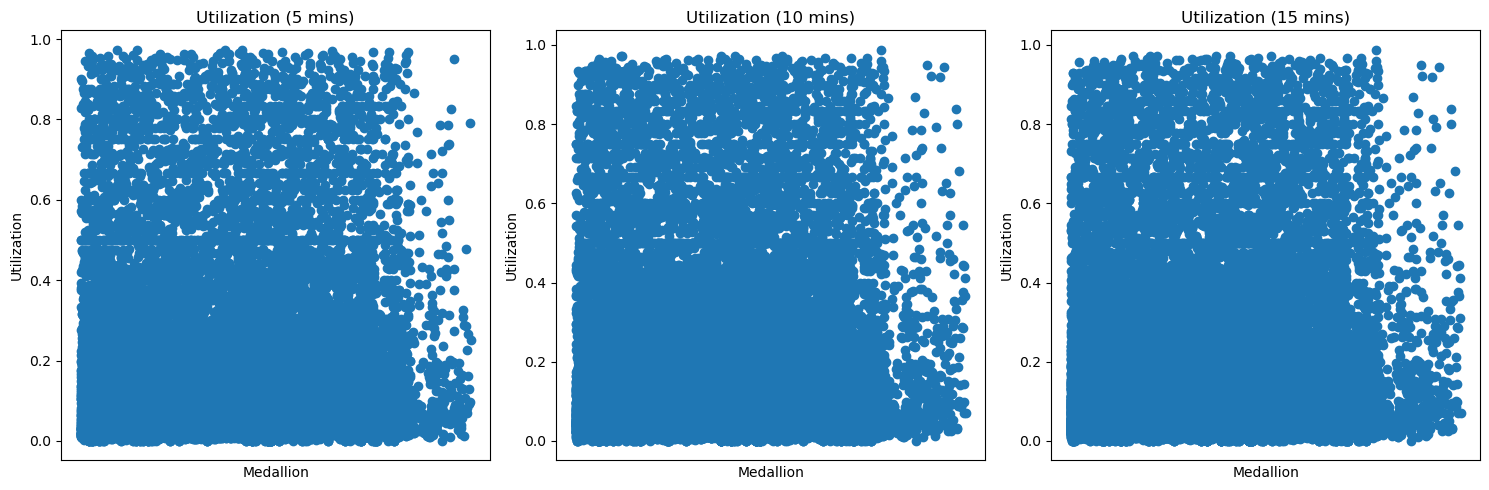

In [268]:
import matplotlib.pyplot as plt

util_5_pd = util_5.toPandas()
util_10_pd = util_10.toPandas()
util_15_pd = util_15.toPandas()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(util_5_pd['medallion'], util_5_pd['utilization'])
axs[0].set_title('Utilization (5 mins)')
axs[0].set_xlabel('Medallion')
axs[0].set_ylabel('Utilization')
axs[0].set_xticks([])  

axs[1].scatter(util_10_pd['medallion'], util_10_pd['utilization'])
axs[1].set_title('Utilization (10 mins)')
axs[1].set_xlabel('Medallion')
axs[1].set_ylabel('Utilization')
axs[1].set_xticks([]) 

axs[2].scatter(util_15_pd['medallion'], util_15_pd['utilization'])
axs[2].set_title('Utilization (15 mins)')
axs[2].set_xlabel('Medallion')
axs[2].set_ylabel('Utilization')
axs[2].set_xticks([])

plt.tight_layout()
plt.show()

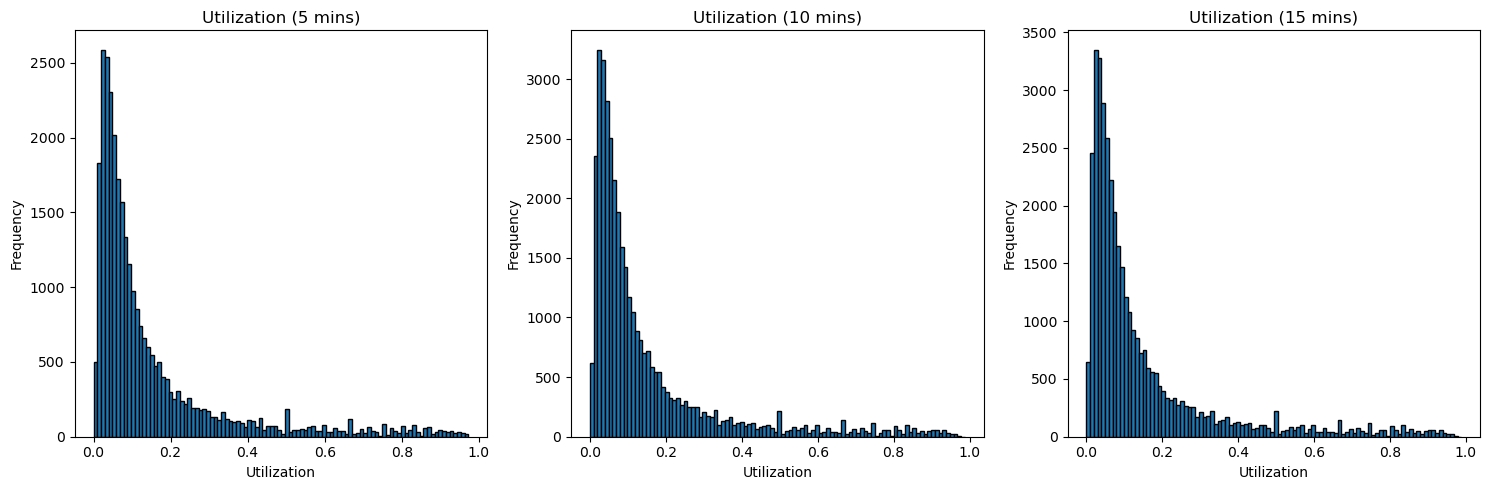

In [272]:
import matplotlib.pyplot as plt

util_5_pd = util_5.toPandas()
util_10_pd = util_10.toPandas()
util_15_pd = util_15.toPandas()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].hist(util_5_pd['utilization'], bins=100, edgecolor='black')
axs[0].set_title('Utilization (5 mins)')
axs[0].set_xlabel('Utilization')
axs[0].set_ylabel('Frequency')

axs[1].hist(util_10_pd['utilization'], bins=100, edgecolor='black')
axs[1].set_title('Utilization (10 mins)')
axs[1].set_xlabel('Utilization')
axs[1].set_ylabel('Frequency')

axs[2].hist(util_15_pd['utilization'], bins=100, edgecolor='black')
axs[2].set_title('Utilization (15 mins)')
axs[2].set_xlabel('Utilization')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [266]:
inmemory_stream(util_5).show()

+--------------------+--------------------+-------------------------+-------------------+-------------------+-------------+----------+--------------------+
|              window|           medallion|duration_before_next_trip|    pickup_datetime|   dropoff_datetime|occupied_time|total_time|         utilization|
+--------------------+--------------------+-------------------------+-------------------+-------------------+-------------+----------+--------------------+
|{2023-12-29 07:25...|58BB45685CC273416...|                    240.0|2013-12-30 03:10:00|2013-12-30 03:14:00|          240|     480.0|                 0.5|
|{2023-12-29 07:45...|9B04FD537919FB639...|                    300.0|2013-12-30 00:17:00|2013-12-30 00:41:00|         1440|    1740.0|  0.8275862068965517|
|{2023-12-29 07:25...|DD91C565768C4FC44...|                  10620.0|2013-12-30 03:34:00|2013-12-30 03:38:00|          240|   10860.0|0.022099447513812154|
|{2023-12-29 06:55...|3A144622F70AAA6E3...|                   55

In [ ]:
stream_utilization_to_sink(util(util_df, 5), "nyc_utilization_5_min_gold", "utilization/5_min_checkpoint")
stream_utilization_to_sink(util(util_df, 10), "nyc_utilization_10_min_gold", "utilization/10_min_checkpoint")
stream_utilization_to_sink(util(util_df, 15), "nyc_utilization_15_min_gold", "utilization/15_min_checkpoint")

### QUERY-2 

The average time it takes for a taxi to find its next fare(trip) per destination borough. This can be computed by finding the time difference, e.g. in seconds, between the trip's drop off and the next trip's pick up within a given unit of time

In [96]:
borough_df = (
    silver_df.select("medallion","dropoff_longitude", "dropoff_latitude", "pickup_longitude", "pickup_latitude", 
                     "pickup_datetime", "dropoff_datetime", "passenger_count", "timestamp")
    .withColumn("stop_borough", find_borough_udf("dropoff_longitude", "dropoff_latitude"))
    .withColumn("start_borough", find_borough_udf("pickup_longitude", "pickup_latitude"))
)

borough_df.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- stop_borough: string (nullable = true)
 |-- start_borough: string (nullable = true)



In [97]:
inmemory_stream(borough_df).show()

+--------------------+-----------------+----------------+----------------+---------------+-------------------+-------------------+---------------+-------------------+------------+-------------+
|           medallion|dropoff_longitude|dropoff_latitude|pickup_longitude|pickup_latitude|    pickup_datetime|   dropoff_datetime|passenger_count|          timestamp|stop_borough|start_borough|
+--------------------+-----------------+----------------+----------------+---------------+-------------------+-------------------+---------------+-------------------+------------+-------------+
|D7D598CD99978BD01...|       -73.981865|        40.73428|       -73.97934|      40.776653|2013-12-01 00:13:00|2013-12-01 00:31:00|              1|2023-12-29 06:07:48|   Manhattan|    Manhattan|
|5455D5FF2BD94D10B...|        -73.98558|       40.718075|      -73.939674|      40.726154|2013-12-01 00:40:00|2013-12-01 00:48:00|              6|2023-12-29 06:07:55|   Manhattan|     Brooklyn|
|93D6821F86A12B537...|       -

In [100]:
avg_df1 = borough_df.selectExpr(
    "medallion", "pickup_datetime", "dropoff_datetime", "timestamp", "start_borough", "stop_borough"
).withWatermark("timestamp", "2 minutes")

avg_df2 = borough_df.selectExpr(
    "medallion AS f_medallion",
    "pickup_datetime AS pick",
    "dropoff_datetime AS drop",
    "timestamp AS f_timestamp",
).withWatermark("f_timestamp", "2 minutes")


avg_df = (avg_df1
    .join(
        avg_df2,
        expr(
            """ 
            medallion = f_medallion AND 
            dropoff_datetime < pick AND
            pick <= dropoff_datetime + interval 5 hours
            """
        )
    )
    .withColumn(
        "duration_before_next_trip",
        unix_timestamp("pick") - unix_timestamp("dropoff_datetime"),
    )
    .drop("f_medallion", "pick", "drop", "f_timestamp")
)

avg_df.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- start_borough: string (nullable = true)
 |-- stop_borough: string (nullable = true)
 |-- duration_before_next_trip: long (nullable = true)



In [101]:
def stream_trip_diff_to_sink(df, topic, checkpoint_path):
    return (df
            .select(to_json(struct("*")).alias("value"))
            .writeStream
            .format("kafka")
            .outputMode("append")
            .trigger(processingTime="1 seconds")
            .option("kafka.bootstrap.servers", BOOTSTRAP_SERVERS)
            .option("topic", topic)
            .option("checkpointLocation", checkpoint_path)
            .start()
    )

In [ ]:
avg_q = stream_trip_diff_to_sink(avg_df, "nyc_trip_diff_v1_silver", "trip_diff_v1_checkpoint")

avg_q.awaitTermination()

In [158]:
avg_q.stop()

In [103]:
avg_v1_schema = StructType(
    [
        StructField("medallion", StringType(), False),
        StructField("pickup_datetime", TimestampType(), False),
        StructField("dropoff_datetime", TimestampType(), False),
        StructField("timestamp", TimestampType(), False),
        StructField("start_borough", StringType(), False),
        StructField("stop_borough", StringType(), False),
        StructField("duration_before_next_trip", IntegerType(), False),
    ]
)

avg_v1_reader = (spark.readStream
    .format("kafka")
    .option("kafka.bootstrap.servers", BOOTSTRAP_SERVERS)
    .option("subscribe", "nyc_trip_diff_v1_silver")
    .option("startingOffsets", "earliest")
    .option("maxOffsetsPerTrigger", 100)
    .load()
    .select(from_json(col("value").cast("string"), avg_v1_schema).alias("parsed_value"))
    .select("parsed_value.*")
)

avg_v1_reader.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- start_borough: string (nullable = true)
 |-- stop_borough: string (nullable = true)
 |-- duration_before_next_trip: integer (nullable = true)



In [110]:
avg_v2 = (
    avg_v1_reader.selectExpr("*")
    .withWatermark("timestamp", "1 minutes")
    .groupBy("medallion", "pickup_datetime","dropoff_datetime", 
            "start_borough", "stop_borough",window("timestamp", "10 minutes"))
    .agg(
        min("duration_before_next_trip").alias("duration_before_next_trip"),
        count("duration_before_next_trip").alias("duplicate_trip_count"),
        avg("duration_before_next_trip").alias("avg_duration_before_next_trip")
    )
)

avg_v2.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- start_borough: string (nullable = true)
 |-- stop_borough: string (nullable = true)
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- duration_before_next_trip: integer (nullable = true)
 |-- duplicate_trip_count: long (nullable = false)
 |-- avg_duration_before_next_trip: double (nullable = true)



In [111]:
inmemory_stream(avg_v2).show(truncate=False)

+--------------------------------+-------------------+-------------------+-------------+------------+------------------------------------------+-------------------------+--------------------+-----------------------------+
|medallion                       |pickup_datetime    |dropoff_datetime   |start_borough|stop_borough|window                                    |duration_before_next_trip|duplicate_trip_count|avg_duration_before_next_trip|
+--------------------------------+-------------------+-------------------+-------------+------------+------------------------------------------+-------------------------+--------------------+-----------------------------+
|64207315352C1899CA48E712BDE706A6|2013-12-30 15:38:00|2013-12-30 15:43:00|Manhattan    |Manhattan   |{2023-12-29 06:40:00, 2023-12-29 06:50:00}|9240                     |1                   |9240.0                       |
|066E412905F56CE0CF60D9393627A978|2013-12-30 17:47:00|2013-12-30 17:59:00|Manhattan    |Manhattan   |{2023-12-29

In [ ]:
avg_v2_stream = stream_trip_diff_to_sink(avg_v2, "nyc_trip_diff_v2_gold", "trip_diff_v2_gold_checkpoint")

avg_v2_stream.awaitTermination()

In [133]:
avg_v2_schema = StructType(
    [
        StructField("medallion", StringType(), False),
        StructField("pickup_datetime", TimestampType(), False),
        StructField("dropoff_datetime", TimestampType(), False),
        StructField("timestamp", TimestampType(), False),
        StructField("start_borough", StringType(), False),
        StructField("stop_borough", StringType(), False),
        StructField("duration_before_next_trip", IntegerType(), False),
    ]
)

nyc_tripdiff_df = kafka_readstream("nyc_trip_diff_v2_gold", avg_v2_schema)

In [137]:
inmemory_stream(nyc_tripdiff_df.selectExpr("*")).show(truncate=False)

+--------------------------------+-------------------+-------------------+-------------------+-------------+------------+-------------------------+
|medallion                       |pickup_datetime    |dropoff_datetime   |timestamp          |start_borough|stop_borough|duration_before_next_trip|
+--------------------------------+-------------------+-------------------+-------------------+-------------+------------+-------------------------+
|40E882BDD06233B5C99288FFED13F6A1|2013-12-01 16:51:00|2013-12-01 17:16:00|2023-12-29 06:16:12|Queens       |Manhattan   |8880                     |
|D7D598CD99978BD012A87A76A7C891B7|2013-12-01 00:13:00|2013-12-01 00:31:00|2023-12-29 06:07:48|Manhattan    |Manhattan   |9780                     |
|B672154F0FD3D6B5277580C3B7CBBF8E|2013-12-01 08:18:00|2013-12-01 08:24:00|2023-12-29 06:10:08|Manhattan    |Manhattan   |660                      |
|1B96632294C366D4BDF08099BCAA6E39|2013-12-01 14:50:00|2013-12-01 14:58:00|2023-12-29 06:12:07|Manhattan    |Manh

In [153]:
borough_avg_duration_df = (
    nyc_tripdiff_df.selectExpr("*")
    .withWatermark("timestamp", "30 minutes")
    .groupBy(window("timestamp", "30 minutes"), "stop_borough")
    .agg(
        count("stop_borough").alias("borough_stop_count"),
        avg("duration_before_next_trip").alias("borough_avg_duration_before_next_trip"),
        min("pickup_datetime").alias("min_pickup"),
        max("dropoff_datetime").alias("max_dropoff"),
    )
    .withColumn("avg_duration_in_minutes", col("borough_avg_duration_before_next_trip") / 60)
)

borough_avg_duration_df.printSchema()

root
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- stop_borough: string (nullable = true)
 |-- borough_stop_count: long (nullable = false)
 |-- borough_avg_duration_before_next_trip: double (nullable = true)
 |-- avg_duration_in_minutes: double (nullable = true)



In [156]:
borough_avg_duration_res = inmemory_stream(borough_avg_duration_df, wait_seconds=60*5)

borough_avg_duration_res.show(truncate=False)

+------------------------------------------+------------+------------------+-------------------------------------+-----------------------+
|window                                    |stop_borough|borough_stop_count|borough_avg_duration_before_next_trip|avg_duration_in_minutes|
+------------------------------------------+------------+------------------+-------------------------------------+-----------------------+
|{2023-12-29 06:00:00, 2023-12-29 06:30:00}|Brooklyn    |2                 |8070.0                               |134.5                  |
|{2023-12-29 06:00:00, 2023-12-29 06:30:00}|Manhattan   |28                |7519.285714285715                    |125.32142857142858     |
|{2023-12-29 07:00:00, 2023-12-29 07:30:00}|Queens      |5                 |6192.0                               |103.2                  |
|{2023-12-29 06:30:00, 2023-12-29 07:00:00}|Other       |2                 |11400.0                              |190.0                  |
|{2023-12-29 07:00:00, 2023

In [97]:
inmemory_stream(avg_df).show()

+--------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------------+
|           medallion|    pickup_datetime|   dropoff_datetime|          timestamp|         f_medallion|               pick|               drop|        f_timestamp|duration_before_next_trip|
+--------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------------+
|D7D598CD99978BD01...|2013-12-01 00:13:00|2013-12-01 00:31:00|2023-12-29 06:07:48|D7D598CD99978BD01...|2013-12-01 03:14:00|2013-12-01 03:29:00|2023-12-29 06:16:54|                     9780|
|B59548DC9A0E62AC3...|2013-12-01 01:49:00|2013-12-01 01:57:00|2023-12-29 06:19:21|B59548DC9A0E62AC3...|2013-12-01 07:18:00|2013-12-01 07:23:00|2023-12-29 06:10:01|                    19260|
|3F390CB15E5448BDD...|2013-12-01 05:21:00|2013-12-

In [168]:
avg_medallion_borough_df = kafka_readstream("nyc_trip_diff_v1_gold", avg_v1_schema)
avg_medallion_borough_df.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- start_borough: string (nullable = true)
 |-- stop_borough: string (nullable = true)
 |-- duration_before_next_trip: integer (nullable = true)



In [169]:
avg_medallion_borough_df = ( avg_medallion_borough_df
                            .selectExpr("*")
                            .withWatermark("timestamp", "10 minutes")
                            .groupBy("medallion", "stop_borough", window("timestamp", "10 minutes"))
                            .agg(
                                avg("duration_before_next_trip").alias("medallion_avg_duration_before_next_trip")
                            )
                            .withColumn("medallion_avg_duration_before_next_trip_mins", expr("medallion_avg_duration_before_next_trip / 60"))
)

In [180]:
avg_medallion_borough_result = inmemory_stream(avg_medallion_borough_df, wait_seconds=60*10)

In [173]:
avg_medallion_borough_result.show()

+--------------------+------------+--------------------+---------------------------------------+--------------------------------------------+
|           medallion|stop_borough|              window|medallion_avg_duration_before_next_trip|medallion_avg_duration_before_next_trip_mins|
+--------------------+------------+--------------------+---------------------------------------+--------------------------------------------+
|8D8BCB635B9DD8552...|   Manhattan|{2023-12-29 06:40...|                                13860.0|                                       231.0|
|0DF80FDB0E48E1A25...|   Manhattan|{2023-12-29 07:00...|                                 9600.0|                                       160.0|
|38E96880D8FA6F448...|       Other|{2023-12-29 06:30...|                                 9360.0|                                       156.0|
|BCEB2F048FCA6F2DB...|   Manhattan|{2023-12-29 06:20...|                                 3540.0|                                        59.0|
|33C5C

In [178]:
import matplotlib.pyplot as plt

def plot_avg_duration_before_next_trip(avg_medallion_borough_df):
    avg_medallion_borough_pd = avg_medallion_borough_df.toPandas()
    boroughs = avg_medallion_borough_pd['stop_borough'].unique()
    borough_colors = {
        'Manhattan': 'blue',
        'Brooklyn': 'green',
        'Queens': 'red',
        'Bronx': 'purple',
        'Staten Island': 'orange',
        'Other': 'gray'
    }
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    for i, borough in enumerate(boroughs):
        row = i // 3
        col = i % 3
        borough_df = avg_medallion_borough_pd[avg_medallion_borough_pd['stop_borough'] == borough]

        axs[row, col].bar(borough_df['medallion'], borough_df['medallion_avg_duration_before_next_trip_mins'], color=borough_colors[borough])
        axs[row, col].set_title(f'{borough}')
        axs[row, col].set_xticks([])

    if len(boroughs) < 6:
        for i in range(len(boroughs), 6):
            row = i // 3
            col = i % 3
            fig.delaxes(axs[row][col])

    plt.tight_layout()
    plt.show()

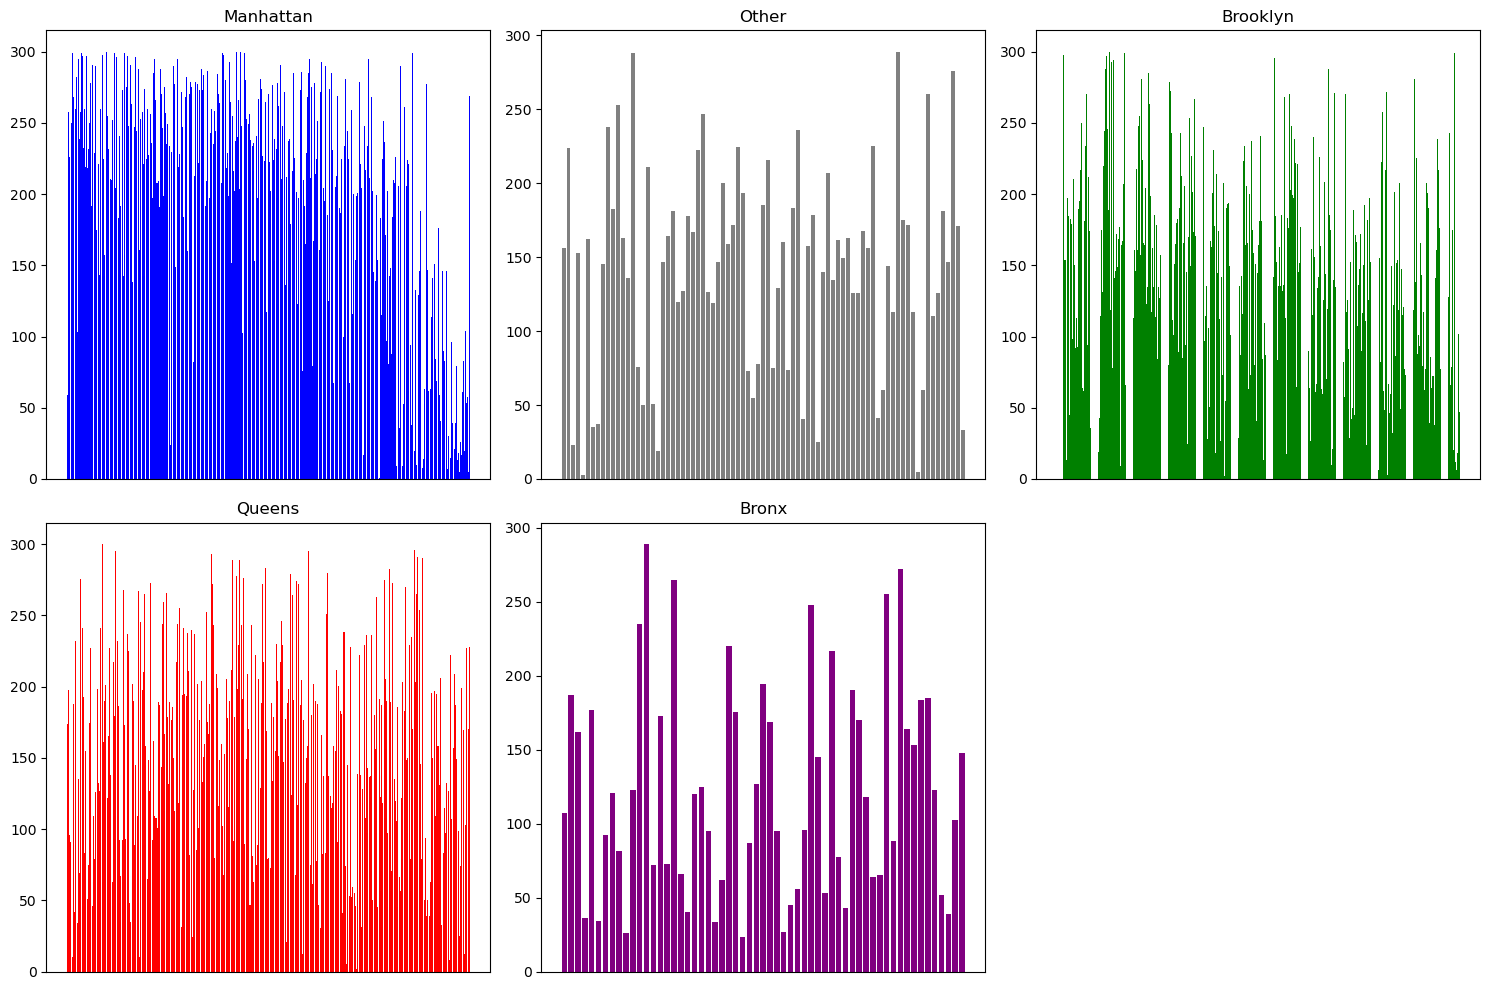

In [181]:
plot_avg_duration_before_next_trip(avg_medallion_borough_result)

### QUERY-3

The number of trips that started and ended within the same borough in the last hour

In [224]:
same_borough_trips = kafka_readstream("nyc_trip_diff_v2_silver", avg_v1_schema, maxOffsetsPerTrigger=200)

same_borough_trips = (
    same_borough_trips.selectExpr("*")
    .filter(col("start_borough") == col("stop_borough"))
    .withWatermark("timestamp", "24 hours")
    .groupBy(window("timestamp", "24 hours"), "start_borough")
    .agg(
        count("*").alias("trip_count"),
    )
)

same_borough_trips.printSchema()

root
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- start_borough: string (nullable = true)
 |-- trip_count: long (nullable = false)



In [ ]:
kafka_writestream(same_borough_trips, "nyc_same_borough_trips_gold", "same_borough_trips_checkpoint")

In [226]:
same_borough_trips = inmemory_stream(same_borough_trips, output_mode="update", wait_seconds=60*10)

In [235]:
def create_map(boroughs):
    global NYC_COORDINATES, NYC_BOROUGHS_GEOJSON

    m = folium.Map(location=NYC_COORDINATES, zoom_start=11)
    with open(NYC_BOROUGHS_GEOJSON, "r") as f:
        nyc_data = f.read()
    folium.GeoJson(nyc_data, name="NeyYork City").add_to(m)
    folium.LayerControl().add_to(m)

    borough_colors = {
        'Manhattan': 'blue',
        'Brooklyn': 'green',
        'Queens': 'red',
        'Bronx': 'purple',
        'Staten Island': 'orange',
        'Other': 'gray'
    }

    borough_coordinates = {
        'Manhattan': [40.7831, -73.9712],
        'Brooklyn': [40.6782, -73.9442],
        'Queens': [40.7282, -73.7949],
        'Bronx': [40.8448, -73.8648],
        'Staten Island': [40.5795, -74.1502],
        'Other': [40.5795, -74.1502]
    }

    for borough in boroughs:
        borough_name = "Staten Island" if borough["start_borough"] == "Other" else borough["start_borough"] 
        tooltip = f"""
        <h3>{borough_name}</h3>
        <h5>Trips: {borough["trip_count"]}</h5>
        """
        borough_color = borough_colors[borough_name]
        borough_cords = borough_coordinates[borough_name]
        folium.Marker(
            location=borough_cords,
            tooltip=tooltip,
            popup=tooltip,
            icon=folium.Icon(color=borough_color, icon="inf"),
        ).add_to(m)

    return m


def convert_df_to_map(df):
    pd_df = df.toPandas()
    pd_df = pd_df.groupby("start_borough").agg({"trip_count": "sum"}).reset_index()
    return create_map(pd_df.to_dict(orient="records"))

<div>
    <img src="..\docs\images\m1.png" width="600" />
    <img src="..\docs\images\m2.png" width="600" />
    <img src="..\docs\images\m3.png" width="600" />
</div>

In [236]:
convert_df_to_map(same_borough_trips)

In [228]:
same_borough_trips.printSchema()

root
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- start_borough: string (nullable = true)
 |-- trip_count: long (nullable = false)



### QUERY-4 

The number of trips that started in one borough and ended in another one in the last hour

In [273]:
different_borough_trips = kafka_readstream("nyc_trip_diff_v1_silver", avg_v1_schema, maxOffsetsPerTrigger=200)

different_borough_trips = (
    different_borough_trips.selectExpr("*")
    .filter(col("start_borough") != col("stop_borough"))
    .withWatermark("timestamp", "24 hours")
    .groupBy(window("timestamp", "24 hours"), "start_borough", "stop_borough")
    .agg(
        count("start_borough").alias("start_count"),
        count("stop_borough").alias("stop_count"),
    )
)

same_borough_trips.printSchema()

root
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- start_borough: string (nullable = true)
 |-- trip_count: long (nullable = false)



In [ ]:
kafka_writestream(different_borough_trips, "nyc_different_borough_trips_gold", "different_borough_trips_checkpoint")

In [313]:
def create_map(boroughs):
    global NYC_COORDINATES, NYC_BOROUGHS_GEOJSON

    m = folium.Map(location=NYC_COORDINATES, zoom_start=11)
    with open(NYC_BOROUGHS_GEOJSON, "r") as f:
        nyc_data = f.read()
    folium.GeoJson(nyc_data, name="NeyYork City").add_to(m)
    folium.LayerControl().add_to(m)

    borough_colors = {
        'Manhattan': 'blue',
        'Brooklyn': 'green',
        'Queens': 'red',
        'Bronx': 'purple',
        'Staten Island': 'orange',
        'Other': 'gray'
    }

    borough_coordinates = {
        'Manhattan': [40.7831, -73.9712],
        'Brooklyn': [40.6782, -73.9442],
        'Queens': [40.7282, -73.7949],
        'Bronx': [40.8448, -73.8648],
        'Staten Island': [40.5795, -74.1502],
        'Other': [40.5795, -74.1502]
    }

    for borough in boroughs.items():
        borough_name = "Staten Island" if borough[0] == "Other" else borough[0] 
        borough = borough[1]
        borough_color = borough_colors[borough_name]
        borough_cords = borough_coordinates[borough_name]
        tooltip = f"""
        <div style="width:200px; color:{borough_color}">
        <h3>{borough_name}</h3>
        <ul>
            <li><h5>Start Count: {borough.get("total_start_count")}</h5></li>
            <li><h5>Stop Count: {borough.get("total_stop_count")}</h5></li>
            <li><h5>Total: {borough.get("total_stop_count")}</h5></li>

        </ul>
        </div>
        """

        folium.Marker(
            location=borough_cords,
            tooltip=tooltip,
            popup=tooltip,
            icon=folium.Icon(color=borough_color, icon="inf"),
        ).add_to(m)

    return m


def convert_df_to_map(df):
    pd_df = df.toPandas()
    tracker_dict = {
        'Manhattan': {},
        'Brooklyn': {},
        'Queens': {},
        'Bronx': {},
        'Staten Island': {},
        'Other': {}
    }

    for index, row in pd_df.iterrows():
        start_borough = row['start_borough']
        stop_borough = row['stop_borough']
        start_count = row['start_count']
        stop_count = row['stop_count']


        tracker_dict[start_borough]["total_start_count"] = tracker_dict[start_borough].get("total_start_count", 0) + start_count
        tracker_dict[stop_borough]["total_stop_count"] = tracker_dict[stop_borough].get("total_stop_count", 0) + stop_count
        tracker_dict[start_borough]["total_trip_count"] = tracker_dict[start_borough].get("total_trip_count", 0) + start_count
        tracker_dict[stop_borough]["total_trip_count"] = tracker_dict[stop_borough].get("total_trip_count", 0) + stop_count

    return tracker_dict

In [274]:
diff_borough_trips = inmemory_stream(different_borough_trips, output_mode="update", wait_seconds=60*5)

In [277]:
diff_borough_trips.printSchema()

root
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- start_borough: string (nullable = true)
 |-- stop_borough: string (nullable = true)
 |-- start_count: long (nullable = false)
 |-- stop_count: long (nullable = false)



In [279]:
a = convert_df_to_map(diff_borough_trips)

In [314]:
create_map(a)

<div>
    <img src="..\docs\images\q41.png" width="600" />
    <img src="..\docs\images\q42.png" width="600" />
    <img src="..\docs\images\q43.png" width="600" />
</div>

### Cleanup

In [ ]:
spark.stop()